In [50]:
#libraries
import os
import cv2
import numpy as np
import pandas as pd

In [51]:
df =pd.read_csv("/content/keras_normal_casev88.csv")

In [52]:
df.head()

,images,p_centriod,g_left_top,g_right_bottom,g_human,confidence_score,p_human,p_left_top,p_right_bottom,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,image_test (01).jpg,"[0, 0]","[0, 0]","[0, 0]",0,0.000000,0,"[0, 0]","[0, 0]",NaN,NaN,0.599885,0.577803,0.504291
1,image_test (02).jpg,"[0, 0]","[0, 0]","[0, 0]",0,0.000000,0,"[0, 0]","[0, 0]",NaN,NaN,NaN,NaN,NaN
2,image_test (03).jpg,"[20.0, 59.25]","[13,31]","[34,95]",1,0.969260,1,"[10, 19]","[35, 94]",NaN,NaN,NaN,NaN,NaN
3,image_test (04).jpg,"[44.0, 64.0]","[35,37]","[54,95]",1,0.999982,1,"[34, 24]","[59, 95]",NaN,NaN,NaN,NaN,NaN
4,image_test (05).jpg,"[0, 0]","[0, 0]","[0, 0]",0,0.000000,0,"[0, 0]","[0, 0]",NaN,NaN,NaN,NaN,NaN


In [53]:
df = df.fillna("[0,0]")

In [54]:
import ast

In [55]:
df["g_left_top"] = df["g_left_top"].apply(ast.literal_eval)
df["g_right_bottom"] = df["g_right_bottom"].apply(ast.literal_eval)
df["p_left_top"] = df["p_left_top"].apply(ast.literal_eval)
df["p_right_bottom"] = df["p_right_bottom"].apply(ast.literal_eval)

In [56]:
pip install torchmetrics

In [57]:
import torch
from torchmetrics.detection import IntersectionOverUnion

In [58]:
iou = []

In [59]:
for index, row in df.iterrows():
  if(row["g_human"]==1) & (row["p_human"]==1):
    preds = [
    {
        "boxes": torch.tensor([
              [row["g_left_top"][0] , row["g_left_top"][1], row["g_right_bottom"][0], row["g_right_bottom"][1]]]),
        "labels": torch.tensor([1]),
    }
    ]
    target = [

      {
          "boxes": torch.tensor([ [row["p_left_top"][0] , row["p_left_top"][1], row["p_right_bottom"][0], row["p_right_bottom"][1]]]),
          "labels": torch.tensor([1]),
      }
     ]
    metric = IntersectionOverUnion()
    iou_value = metric(preds, target)
    iou.append(iou_value['iou'])
  else:
    iou.append(0)

In [60]:
df['IOU'] = iou

In [61]:
df_sorted = df.sort_values(by='confidence_score', ascending=False)

In [62]:
df_sorted.head()

,images,p_centriod,g_left_top,g_right_bottom,g_human,confidence_score,p_human,p_left_top,p_right_bottom,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,IOU
3,image_test (04).jpg,"[44.0, 64.0]","[35, 37]","[54, 95]",1,0.999982,1,"[34, 24]","[59, 95]","[0,0]","[0,0]","[0,0]","[0,0]","[0,0]",tensor(0.6208)
20,image_test (21).jpg,"[28.0, 64.0]","[38, 33]","[66, 95]",1,0.999969,1,"[18, 24]","[43, 95]","[0,0]","[0,0]","[0,0]","[0,0]","[0,0]",tensor(0.0968)
8,image_test (09).jpg,"[64.0, 64.0]","[52, 35]","[74, 95]",1,0.999969,1,"[54, 24]","[79, 95]","[0,0]","[0,0]","[0,0]","[0,0]","[0,0]",tensor(0.6332)
18,image_test (19).jpg,"[44.0, 64.0]","[33, 39]","[56, 95]",1,0.999968,1,"[34, 24]","[59, 95]","[0,0]","[0,0]","[0,0]","[0,0]","[0,0]",tensor(0.6729)
17,image_test (18).jpg,"[36.0, 63.25]","[23, 36]","[47, 95]",1,0.999920,1,"[26, 23]","[51, 95]","[0,0]","[0,0]","[0,0]","[0,0]","[0,0]",tensor(0.6267)


In [63]:
preds =0
ground = 0

In [64]:
preds = df_sorted["g_human"].sum()
ground = df_sorted["p_human"].sum()

calculate precision-recall for varying IOU

In [65]:
tps = []
fps = []

In [66]:
for index, row in df_sorted.iterrows():
    #print(row['ground_truth'], row['predicted'])
    if (row['IOU']>0.5):
      tps.append(1)
      fps.append(0)
    else:
      tps.append(0)
      fps.append(1)

In [67]:
df_sorted["tps"] = tps
df_sorted["fps"] = fps

In [68]:
cumulative_fps = df_sorted["fps"].cumsum()
cumulative_tps = df_sorted["tps"].cumsum()

In [69]:
recalls_05 = np.divide(cumulative_tps, ground)
precisions_05 = np.divide(cumulative_tps, (cumulative_fps + cumulative_tps))

In [70]:
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [71]:
decreasing_max_precision_05 = np.maximum.accumulate(precisions_05[::-1])[::-1]

In [72]:
ap05 = compute_ap(recalls_05, decreasing_max_precision_05)

In [73]:
tps = []
fps = []

In [74]:
for index, row in df_sorted.iterrows():
    #print(row['ground_truth'], row['predicted'])
    if (row['IOU']>0.25):
      tps.append(1)
      fps.append(0)
    else:
      tps.append(0)
      fps.append(1)

In [75]:
df_sorted["tps_025"] = tps
df_sorted["fps_025"] = fps

In [76]:
cumulative_fps = df_sorted["fps_025"].cumsum()
cumulative_tps = df_sorted["tps_025"].cumsum()

In [77]:
recalls_025 = np.divide(cumulative_tps, ground)
precisions_025 = np.divide(cumulative_tps, (cumulative_fps + cumulative_tps))

In [78]:
decreasing_max_precision_025 = np.maximum.accumulate(precisions_025[::-1])[::-1]

In [79]:
ap025 = compute_ap(recalls_025, decreasing_max_precision_025)

In [80]:
ap025

0.6816418650793651

In [81]:
tps = []
fps = []

In [82]:
for index, row in df_sorted.iterrows():
    #print(row['ground_truth'], row['predicted'])
    if (row['IOU']>0.1):
      tps.append(1)
      fps.append(0)
    else:
      tps.append(0)
      fps.append(1)

In [83]:
df_sorted["tps_01"] = tps
df_sorted["fps_01"] = fps

In [84]:
cumulative_fps = df_sorted["fps_01"].cumsum()
cumulative_tps = df_sorted["tps_01"].cumsum()

In [85]:
recalls_01 = np.divide(cumulative_tps, ground)
precisions_01 = np.divide(cumulative_tps, (cumulative_fps + cumulative_tps))

In [86]:
decreasing_max_precision_01 = np.maximum.accumulate(precisions_01[::-1])[::-1]

In [87]:
ap01 = compute_ap(recalls_01, decreasing_max_precision_01)

In [88]:
ap01

0.7287996031746031

In [89]:
# from matplotlib.pyplot import figure

# figure(figsize=(12, 8))

<ipython-input-90-39ac81504583>:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(recalls_05, precisions_05, '-r', linestyle='--', label=f"Curve for 0.5 IOU")
<ipython-input-90-39ac81504583>:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-g" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(recalls_025, precisions_025, '-g', linestyle='--', label=f"Curve for 0.25 IOU")
<ipython-input-90-39ac81504583>:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-b" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(recalls_01, precisions_01, '-b', linestyle='--', label=f"Curve for 0.1 IOU")


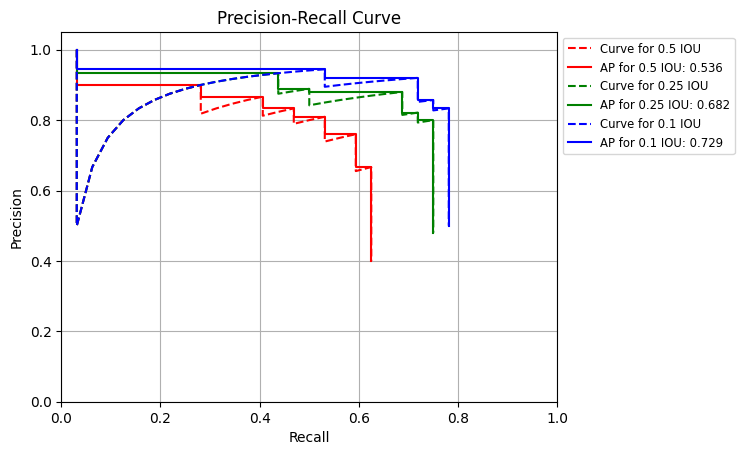

In [90]:
import matplotlib.pyplot as plt

# Plotting the curves
plt.plot(recalls_05, precisions_05, '-r', linestyle='--', label=f"Curve for 0.5 IOU")
plt.step(recalls_05, decreasing_max_precision_05, '-r', label=f"AP for 0.5 IOU: {round(ap05, 3)}")
plt.plot(recalls_025, precisions_025, '-g', linestyle='--', label=f"Curve for 0.25 IOU")
plt.step(recalls_025, decreasing_max_precision_025, '-g', label=f"AP for 0.25 IOU: {round(ap025, 3)}")
plt.plot(recalls_01, precisions_01, '-b', linestyle='--', label=f"Curve for 0.1 IOU")
plt.step(recalls_01, decreasing_max_precision_01, '-b', label=f"AP for 0.1 IOU: {round(ap01, 3)}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(True)

# Placing legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

plt.show()

In [91]:
import numpy as np

# Step 1: Calculate F1 score for each image
f1_scores_01 = [2 * (precisions_01 * recalls_01) / (precisions_01 + recalls_01) if (precisions_01 + recalls_01) != 0 else 0 for precisions_01, recalls_01 in zip(precisions_01, recalls_01)]

# Step 2: Average F1 scores across all images
overall_f1_score_01 = np.mean(f1_scores_01)

print("Overall F1 Score for IOU 0.1:", overall_f1_score_01)

Overall F1 Score for IOU 0.1: 0.5998852396504302


In [92]:
# Step 1: Calculate F1 score for each image
f1_scores_025 = [2 * (precisions_025 * recalls_025) / (precisions_025 + recalls_025) if (precisions_025 + recalls_025) != 0 else 0 for precisions_025, recalls_025 in zip(precisions_025, recalls_025)]

# Step 2: Average F1 scores across all images
overall_f1_score_025 = np.mean(f1_scores_025)

print("Overall F1 Score for IOU 0.25:", overall_f1_score_025)

Overall F1 Score for IOU 0.25: 0.5778029901232984


In [93]:
# Step 1: Calculate F1 score for each image
f1_scores_05 = [2 * (precisions_05 * recalls_05) / (precisions_05 + recalls_05) if (precisions_05 + recalls_05) != 0 else 0 for precisions_05, recalls_05 in zip(precisions_05, recalls_05)]

# Step 2: Average F1 scores across all images
overall_f1_score_05 = np.mean(f1_scores_05)

print("Overall F1 Score for IOU 0.5:", overall_f1_score_05)

Overall F1 Score for IOU 0.5: 0.5042913302139825


<ipython-input-94-a182c365dca4>:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  plt.step(recalls_05, decreasing_max_precision_05, '-r',linestyle='--', label=f"Interpolated precision for IOU>0.5: {round(ap05, 3)}")
<ipython-input-94-a182c365dca4>:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-g" (-> linestyle='-'). The keyword argument will take precedence.
  plt.step(recalls_025, decreasing_max_precision_025,  '-g',linestyle='--', label=f"Interpolated precision for IOU>0.25: {round(ap025, 3)}")
<ipython-input-94-a182c365dca4>:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-b" (-> linestyle='-'). The keyword argument will take precedence.
  plt.step(recalls_01, decreasing_max_precision_01, '-b', linestyle='--',label=f"Interpolated precision for IOU

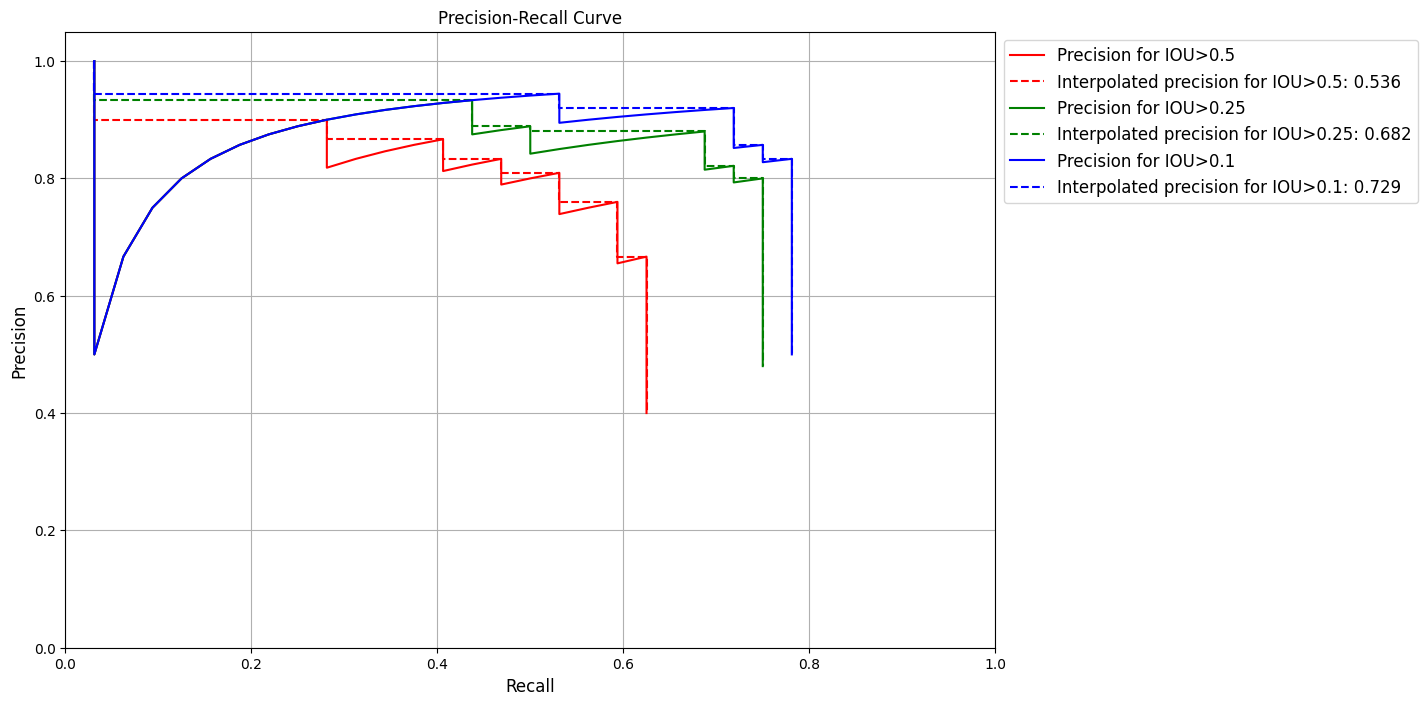

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
# Plotting the curves
plt.plot(recalls_05, precisions_05, '-r', label=f"Precision for IOU>0.5")
plt.step(recalls_05, decreasing_max_precision_05, '-r',linestyle='--', label=f"Interpolated precision for IOU>0.5: {round(ap05, 3)}")
plt.plot(recalls_025, precisions_025, '-g', label=f"Precision for IOU>0.25")
plt.step(recalls_025, decreasing_max_precision_025,  '-g',linestyle='--', label=f"Interpolated precision for IOU>0.25: {round(ap025, 3)}")
plt.plot(recalls_01, precisions_01, '-b',  label=f"Precision for IOU>0.1")
plt.step(recalls_01, decreasing_max_precision_01, '-b', linestyle='--',label=f"Interpolated precision for IOU>0.1: {round(ap01, 3)}")

plt.xlabel('Recall',fontsize = 12)
plt.ylabel('Precision',fontsize = 12)
plt.title('Precision-Recall Curve',fontsize = 12)

plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(True)

# Placing legend outside the plot and increasing font size
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='large')

plt.show()